In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from data_processing.preprocessing import *

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from utils.plotting import *
from model.rnn import *
from model.lstm import *
from model.metrics import *

In [2]:
# Liste des symboles des principales banques européennes
european_banks = [
    'BNP.PA',   # BNP Paribas
    'GLE.PA',   # Société Générale 
    'ACA.PA',   # Crédit Agricole 
    'HSBA.L',   # HSBC (UK)
    'BARC.L',   # Barclays (UK)
    'DBK.DE',   # Deutsche Bank (Germany)
    'UBSG.SW',  # UBS Group (Switzerland)
    'INGA.AS',  # ING Group (Netherlands)
    'ISP.MI',   # Intesa Sanpaolo (Italy)
    'SAN.MC',   # Banco Santander (Spain)
    'BBVA.MC'   # BBVA (Spain)
]

# à partir de 2013
start_date = '2013-01-01'
end_date = '2024-11-07'

data = prepare_stock_data(european_banks, start_date, end_date)

# Filtrer les colonnes associées à BNP.PA
bnp_data = data['BNP.PA']  # Cela sélectionne toutes les sous-colonnes sous 'BNP.PA'

# (Optionnel) Réinitialiser l'index pour une présentation plus lisible
bnp_data = bnp_data.reset_index()

bnp_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

bnp_data['Log Return'] = np.log(bnp_data['Adj Close']) - np.log(bnp_data['Adj Close'].shift(1))
bnp_data = bnp_data.interpolate(method='linear').ffill().bfill()
bnp_data.describe()

Téléchargement des données pour BNP.PA...


[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour GLE.PA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour ACA.PA...
Téléchargement des données pour HSBA.L...


[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour BARC.L...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour DBK.DE...
Téléchargement des données pour UBSG.SW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Téléchargement des données pour INGA.AS...
Téléchargement des données pour ISP.MI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Téléchargement des données pour SAN.MC...



[*********************100%***********************]  1 of 1 completed

Téléchargement des données pour BBVA.MC...
Nombre de valeurs manquantes au début : 0
Nombre total de valeurs manquantes après traitement: 0


,Date,Adj Close,Close,High,Low,Open,Volume,Log Return
count,3043,3043.000000,3043.000000,3043.000000,3043.000000,3043.000000,3.043000e+03,3043.000000
mean,2018-12-06 03:46:40.262898432,36.470400,52.141603,52.753374,51.537340,52.160959,3.989900e+06,0.000324
min,2013-01-02 00:00:00,17.095335,24.670000,25.340000,24.504999,24.900000,0.000000e+00,-0.191166
25%,2015-12-19 12:00:00,28.002009,45.722500,46.414999,45.154999,45.802500,2.753874e+06,-0.009222
50%,2018-12-05 00:00:00,33.479767,52.700001,53.209999,52.099998,52.720001,3.559610e+06,0.000588
75%,2021-11-22 12:00:00,41.960369,58.599998,59.250000,58.029999,58.689999,4.682802e+06,0.010262
max,2024-11-06 00:00:00,68.339996,72.900002,73.080002,72.290001,72.349998,2.133924e+07,0.165351
std,NaN,11.221611,8.747804,8.709128,8.762270,8.731383,1.962344e+06,0.019515


In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

target = bnp_data[['Adj Close']]
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_bnp = scaler.fit_transform(bnp_data[['Adj Close', 'Log Return', 'Volume']])
scaled_bnp = pd.DataFrame(scaled_bnp, columns=['Adj Close', 'Log Return', 'Volume'])

In [4]:
gap = 50  # Gap between each subset

# Calculate dynamic sizes
total_samples = len(scaled_bnp)
train_size = int(0.60 * total_samples)
test_size = int(0.18 * total_samples)
validation_size = int(0.18 * total_samples)

train,test,validation=data_splitting(scaled_bnp,train_size,test_size,validation_size,gap)

<h2>LSTM Model</h2>

In [5]:
timesteps = 10
X_train, y_train = create_sequences(train, target_column='Adj Close', timesteps=timesteps)
X_test, y_test = create_sequences(test, target_column='Adj Close', timesteps=timesteps)
X_validation, y_validation = create_sequences(validation, target_column='Adj Close', timesteps=timesteps)

In [ ]:
# Build and train the LSTM model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))  # Input shape (timesteps, features)
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,961 (50.63 KB)

 Trainable params: 12,961 (50.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0629 - val_loss: 0.0333
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0278 - val_loss: 0.0166
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0101
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0073
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

In [7]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
nse = calculate_nse(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 1.7419
NSE: 0.9566


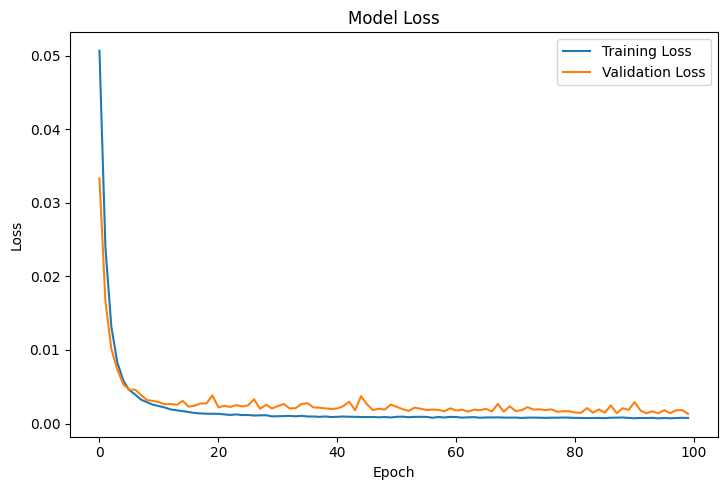

In [8]:
plot_learning_curves(history)

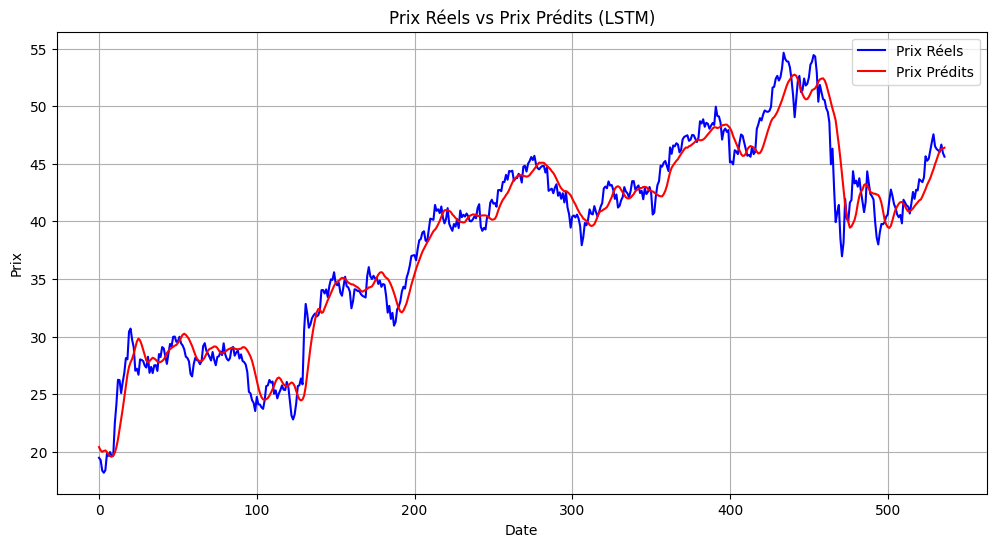

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Prix Réels', color='blue')
plt.plot(y_pred_rescaled, label='Prix Prédits', color='red')
plt.title("Prix Réels vs Prix Prédits (LSTM)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid()
plt.show()

<h2>RNN Model</h2>